## Evaluation Calibration and timeconstant measurements Tsensors

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import io
import glob
from pandas.tseries.offsets import DateOffset

### Bring all files to the same time axis

In [2]:
#load the data files:
filenames = glob.glob("Tsensor_measurements/*.LOG")
path_timeaxis = 'Tsensor_measurements/files_timeaxis/'


#load in the temperature measurement of the Greisinger thermometer for the time constant    
timeconst = pd.read_csv('Tsensor_measurements/tsensor_calibration_time_constant.log', comment='#',
                          names=["time","temperature"])
timeconst['time']= pd.to_datetime(timeconst["time"], utc=True).dt.tz_localize(None)
start_shock = timeconst['time'].values[2]

k=0
millis_start = np.zeros(8,int)

#find the start index of shocking the temperature sensors
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor["time"] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None)
    
    #create timeaxis for files with wrong time axis (DKB and LG)
    if (filename== filenames[2]) or (filename == filenames[6]):
        #set time to time of QR and create artifical time axis using the millis
        tsensor["time"] = tsensor["time"].copy()+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)
        for i in range(0,len(tsensor["time"].values)):
            tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
    
    #calculate temporal temperature changes of each millisecond:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms (temperature seems to be relatively constant 200000ms onwards)
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[k] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[k]]
    
    #calculate offset to laboratoy measurement at shock time and redefine time axis:
    offset = tsensor['time'].values[millis_start[k]]-start_shock    
    tsensor['time'] = tsensor['time']- offset
    
    #store files
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor.to_csv(path_timeaxis + name + '.LOG', header=None, index=False)

    k+=1

<ipython-input-2-cd886ca58cd6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
<ipython-input-2-cd886ca58cd6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


### Calibration

In [3]:
#load the calibration files
calibration = pd.read_csv('Tsensor_measurements/tsensor_calibration.log', sep=',', 
                            comment='#',names=["time","millis","ID","temperature"])
calibration["time"] = pd.to_datetime(calibration["time"], utc=True).dt.tz_localize(None)

In [7]:
##load the files with the corrected timeaixs and create a dataframe interpolated time of correlation laboratory
##measurement
files = glob.glob(path_timeaxis+"*.LOG")

df1 = calibration.copy()
df1_1 = df1[['time','temperature']].rename(columns={"temperature": "Laborary"})
df1_1['time'] = pd.to_datetime(df1["time"], utc=True).dt.tz_localize(None)
df1 = df1_1.copy()

for count, file in enumerate(files[:]):
    name = file.split("/")[-1].split("_")[-1].split(".")[0]
    df2 = pd.read_csv(file, sep=',', comment='#',names=["time","millis","sensorID","temperature"])
    df2 = df2[["time","temperature"]].rename(columns={"temperature": name})
    df2["time"] = pd.to_datetime(df2["time"], utc=True).dt.tz_localize(None)
    df1_1 = pd.merge_ordered(df1_1, df2)
    
df1_1.set_index(['time'], inplace = True)
df1_1 = (df1_1.interpolate(method = "time")).reindex(df1.time)

,Laborary,QR,DKB,DF,KM,KiS,LG,KS,SimonS
time,,,,,,,,,
2023-03-02 16:01:53,3.00,3.31,3.06,3.75,3.250000,3.06,3.471351,4.38,3.06
2023-03-02 16:03:53,4.00,4.38,4.06,4.75,4.232171,4.06,4.380000,5.38,4.00
2023-03-02 16:05:30,5.00,5.25,5.03,5.69,5.190747,5.06,5.374514,6.31,5.00
2023-03-02 16:06:54,6.00,6.25,6.00,6.63,6.130000,6.06,6.310000,7.25,5.94
2023-03-02 16:08:16,7.04,7.19,7.00,7.56,7.060000,7.06,7.310000,8.25,7.00
2023-03-02 16:09:36,8.00,8.25,8.00,8.63,8.073526,8.06,8.310000,9.19,8.00
2023-03-02 16:10:50,9.00,9.19,9.00,9.63,9.060000,9.06,9.310000,10.19,8.94
2023-03-02 16:12:11,10.00,10.13,10.00,10.56,10.055947,10.03,10.310000,11.13,9.94
2023-03-02 16:13:37,11.00,11.19,10.81,11.50,10.880000,10.94,11.130000,12.00,10.88


{'QR': array([ 0.00140693, -0.04060876,  0.44311093]), 'DKB': array([ 0.00119211, -0.02983068,  0.14389312]), 'DF': array([ 0.00171593, -0.04987637,  0.88662819]), 'KM': array([ 0.00219469, -0.06951533,  0.46263249]), 'KiS': array([ 0.00036888, -0.01093385,  0.09981709]), 'LG': array([ 0.00158846, -0.05031084,  0.58245583]), 'KS': array([ 1.47361701e-03, -6.23715667e-02,  1.58281494e+00]), 'SimonS': array([ 0.00075733, -0.02163417,  0.08605323])}


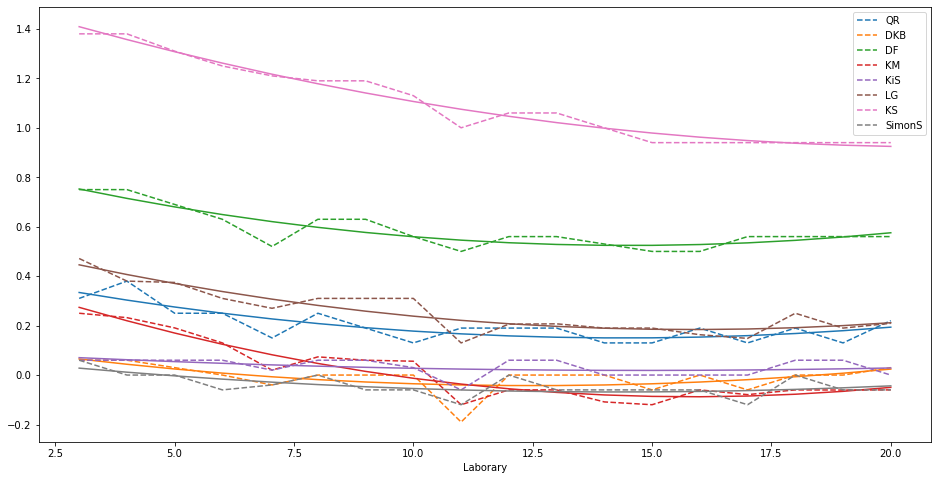

In [10]:
sensor_list = df1_1.columns.values.tolist()[:]

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
     '#7f7f7f', '#bcbd22', '#17becf']

#2nd order polnomial fit for calibration
plt.figure(figsize = (16,8))
fit_y = np.zeros((len(sensor_list[1:]),len(df1_1[sensor_list[0]])))
fit_parameter = {} 
for i, sensor in enumerate(sensor_list[1:]):
    fit_parameter[sensor] = np.polyfit(df1_1[sensor_list[0]].values, df1_1[sensor].values-
                                       df1_1[sensor_list[0]].values, 2)
    fit_y[i] = (fit_parameter[sensor][2]+fit_parameter[sensor][1]*df1_1[sensor_list[0]]+
                fit_parameter[sensor][0]*df1_1[sensor_list[0]]**2)
    
    #plot the fit 
    plt.plot(df1_1[sensor_list[0]],fit_y[i])
    plt.plot(df1_1[sensor_list[0]].values,df1_1[sensor].values-df1_1[sensor_list[0]].values,label = sensor,
             alpha = 1,linestyle = "--",c=c[i])  
plt.xlabel("Laborary") 
plt.legend()

#### Calibration of all files

['Tsensor_measurements/files_timeaxis/QR.LOG', 'Tsensor_measurements/files_timeaxis/DKB.LOG', 'Tsensor_measurements/files_timeaxis/DF.LOG', 'Tsensor_measurements/files_timeaxis/KM.LOG', 'Tsensor_measurements/files_timeaxis/KiS.LOG', 'Tsensor_measurements/files_timeaxis/LG.LOG', 'Tsensor_measurements/files_timeaxis/KS.LOG', 'Tsensor_measurements/files_timeaxis/SimonS.LOG']
Tsensor_measurements/files_timeaxis//calib/


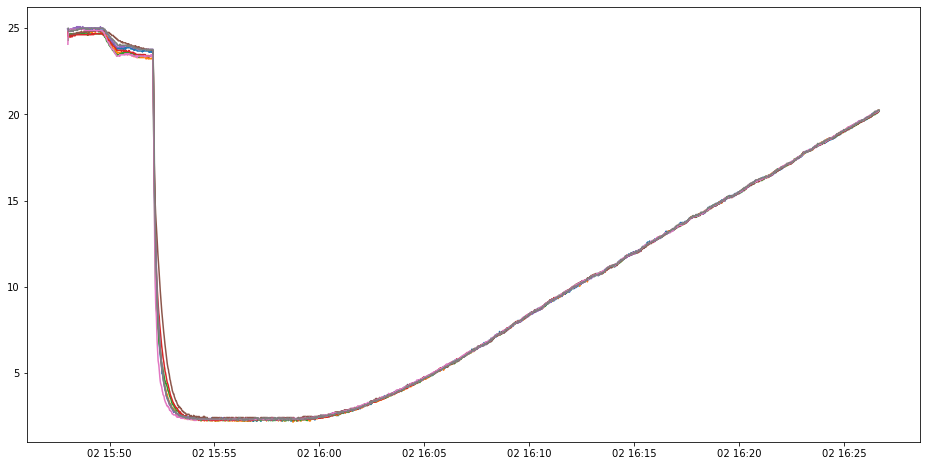

In [15]:
path_storage_calib = path_timeaxis + '/calib/'

k=0
for filename in files:
    #load in all files file by file
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor['time'] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None) 

    #calibration correction of the temperatur
    tsensor['temperature'] = tsensor['temperature'] - (fit_parameter[name][2]+tsensor['temperature']*
                                                       fit_parameter[name][1]+fit_parameter[name][0]*
                                                       tsensor['temperature']**2)
    tsensor.to_csv(path_storage_calib + name + '.LOG', header=None, index=False)
    plt.plot(tsensor['time'], tsensor['temperature'])
    k+=1

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']


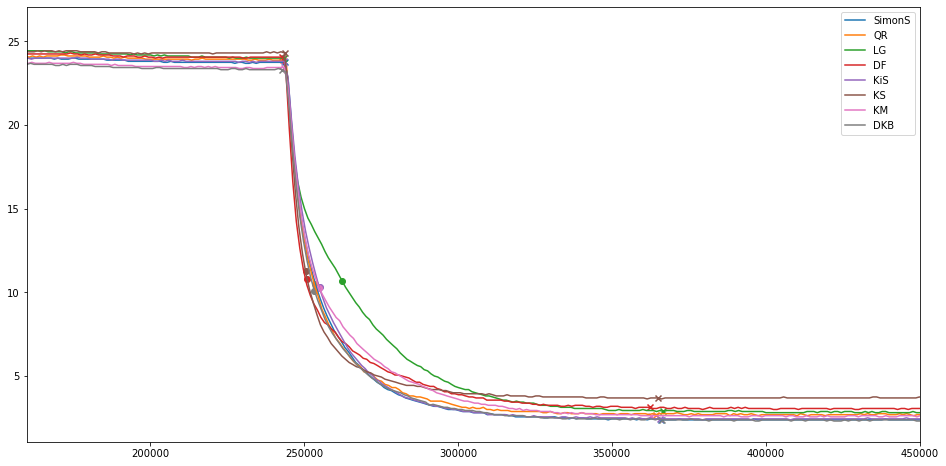

In [6]:
#load the data files:
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)

fig=plt.figure(figsize=(16,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
              '#7f7f7f', '#bcbd22', '#17becf']
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    #print('millis start: ', millis_start[i])
    
    #find "end time", where temporal temperature change over an interval of 100s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100 ##average time
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    #print('end time: ', end_time)
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp start: ', temp_start)
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp end: ',temp_end)
    
    ##calculate temperature and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   Temp tau: ',Temp_tau)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   time tau: ',time_tau)
    
    
    #plot of the sensors:
    plt.plot(tsensor["millis"], tsensor["temperature"], c=c[i], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    plt.scatter(start_time, tsensor['temperature'].values[millis_start[i]],c = c[i], marker='x')
    plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n], c=c[i],
                marker='x')
    plt.scatter(time_tau, Temp_tau)
    plt.legend()
    plt.xlim(160000,450000)
    
    i += 1

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']


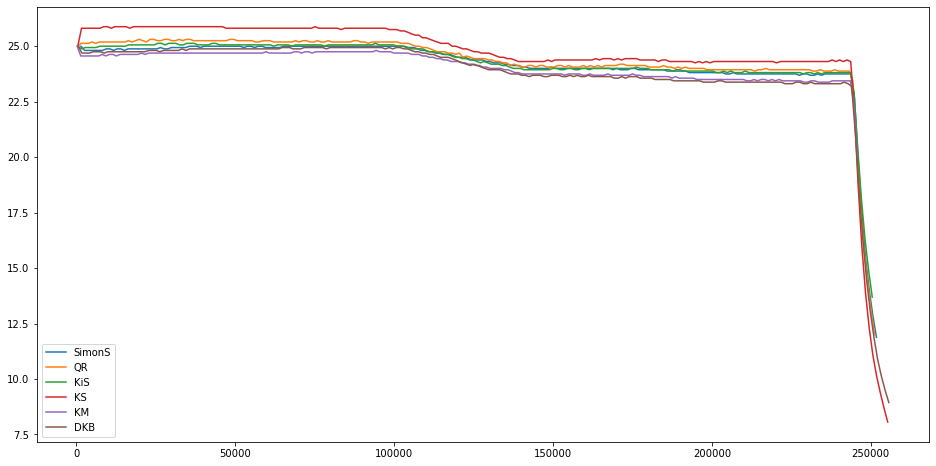

In [315]:
#1. Read in the dataframes and merge then into one dataframe
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)
filenames = filenames[:2] + filenames[4:]

fig=plt.figure(figsize=(16,8))
for filename in filenames:
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    plt.plot(tsensor["millis"][:220], tsensor["temperature"][:220], label = filename.split("/")[-1].split("_")[-1].split(".")[0])
    plt.legend()
#dfs = []
#for filename in filenames:
#    dfs.append(pd.read_csv(filename, sep=',', comment='#',names=["time","group","spot","average"]))

# Concatenate all data into one DataFrame
#big_frame = pd.concat(dfs, ignore_index=True)

#Convert to datetime
#big_frame['time'] = pd.to_datetime(big_frame['time'])

#sort dateframe by date:
#big_frame.sort_values(by='time', inplace=True)

#set index to time
#big_frame.set_index(['time'], inplace=True)

#big_frame.head(16)

['Tsensor_measurements/files_timeaxis//calib/QR.LOG', 'Tsensor_measurements/files_timeaxis//calib/DKB.LOG', 'Tsensor_measurements/files_timeaxis//calib/DF.LOG', 'Tsensor_measurements/files_timeaxis//calib/KM.LOG', 'Tsensor_measurements/files_timeaxis//calib/KiS.LOG', 'Tsensor_measurements/files_timeaxis//calib/LG.LOG', 'Tsensor_measurements/files_timeaxis//calib/KS.LOG', 'Tsensor_measurements/files_timeaxis//calib/SimonS.LOG']


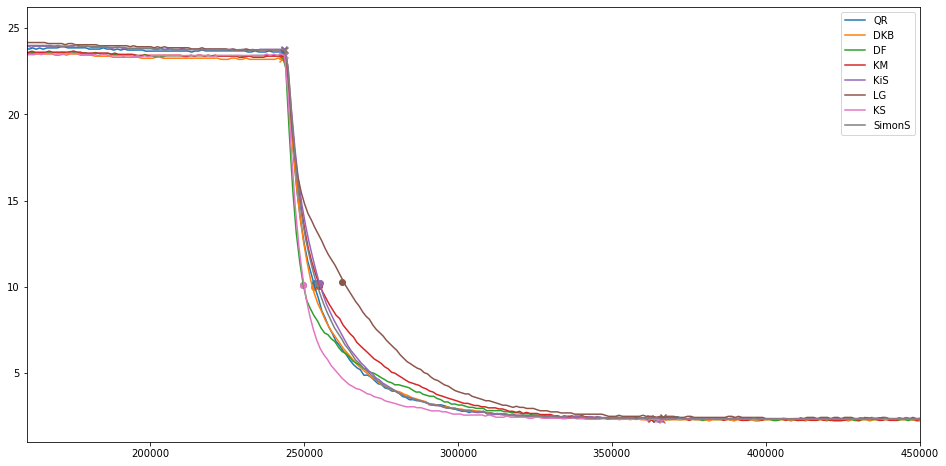

In [380]:
filenames = glob.glob(path_storage_calib+'/*.LOG')
print(filenames)

fig=plt.figure(figsize=(16,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
              '#7f7f7f', '#bcbd22', '#17becf']
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    #print('millis start: ', millis_start[i])
    
    #find "end time", where temporan temperature change over an interval of 60s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100 ##average time
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    #print('end time: ', end_time)
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp start: ', temp_start)
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   temp end: ',temp_end)
    
    ##calculate temperature and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   Temp tau: ',Temp_tau)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    #print(filename.split("/")[-1].split("_")[-1].split(".")[0] + '   time tau: ',time_tau)
    
    
    #plot of the sensors:
    plt.plot(tsensor["millis"], tsensor["temperature"], c=c[i], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    plt.scatter(start_time, tsensor['temperature'].values[millis_start[i]],c = c[i], marker='x')
    plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n], c=c[i],
                marker='x')
    plt.scatter(time_tau, Temp_tau)
    plt.legend()
    plt.xlim(160000,450000)
    
    i += 1

## Calibration

In [317]:
millis_start

array([212, 212, 217, 211, 213, 209, 217, 208])

In [318]:
calibration = pd.read_csv('Tsensor_measurements/tsensor_calibration_time_constant.log', comment='#',
                          names=["time","temperature"])
calibration['time']= pd.to_datetime(calibration["time"], utc=True).dt.tz_localize(None)
start_shock = calibration['time'].values[2]
start_shock

numpy.datetime64('2023-03-02T15:52:04.000000000')

In [319]:
calibration

,time,temperature
0,2023-03-02 15:49:56,24.38
1,2023-03-02 15:51:51,23.53
2,2023-03-02 15:52:04,7.60
3,2023-03-02 15:52:38,3.90
4,2023-03-02 15:52:43,3.30
5,2023-03-02 15:52:53,2.90
6,2023-03-02 15:53:03,2.70
7,2023-03-02 15:53:13,2.60
8,2023-03-02 15:53:23,2.50
9,2023-03-02 15:53:33,2.45


In [320]:
calibration_2 = pd.read_csv('Tsensor_measurements/tsensor_calibration.log', sep=',', comment='#',names=["time","millis","ID","temperature"])
calibration_2["time"] = pd.to_datetime(calibration_2["time"], utc=True).dt.tz_localize(None)

In [321]:
calibration_2

,time,millis,ID,temperature
0,2023-03-02 16:01:53,0,Labor,3.00
1,2023-03-02 16:03:53,0,Labor,4.00
2,2023-03-02 16:05:30,0,Labor,5.00
3,2023-03-02 16:06:54,0,Labor,6.00
4,2023-03-02 16:08:16,0,Labor,7.04
5,2023-03-02 16:09:36,0,Labor,8.00
6,2023-03-02 16:10:50,0,Labor,9.00
7,2023-03-02 16:12:11,0,Labor,10.00
8,2023-03-02 16:13:37,0,Labor,11.00
9,2023-03-02 16:15:10,0,Labor,12.00


Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']

['Tsensor_measurements/TSENSOR_SimonS.LOG', 'Tsensor_measurements/TSENSOR_QR.LOG', 'Tsensor_measurements/TSENSOR_LG.LOG', 'Tsensor_measurements/TSENSOR_DF.LOG', 'Tsensor_measurements/TSENSOR_KiS.LOG', 'Tsensor_measurements/TSENSOR_KS.LOG', 'Tsensor_measurements/TSENSOR_KM.LOG', 'Tsensor_measurements/TSENSOR_DKB.LOG']
SimonS
shock time old: 2023-03-02 15:52:08
offset:  2023-03-02 15:48:02
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:02
QR
shock time old: 2023-03-02 15:51:57
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


<ipython-input-322-1bae452047cf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


LG
shock time old: 2023-03-02 15:52:03.489000
offset:  2023-03-02 15:48:03.056000
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:03.056000
DF
shock time old: 2023-03-02 15:51:58
offset:  2023-03-02 15:48:02
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:02
KiS
shock time old: 2023-03-02 15:51:59
offset:  2023-03-02 15:48:00
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:00
KS
shock time old: 2023-03-02 15:51:53
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


<ipython-input-322-1bae452047cf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


KM
shock time old: 2023-03-02 15:52:03.584000
offset:  2023-03-02 15:48:00.698000
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:00.698000
DKB
shock time old: 2023-03-02 15:32:29
offset:  2023-03-02 15:48:01
shock time:  2023-03-02 15:52:04
start time:  2023-03-02 15:48:01


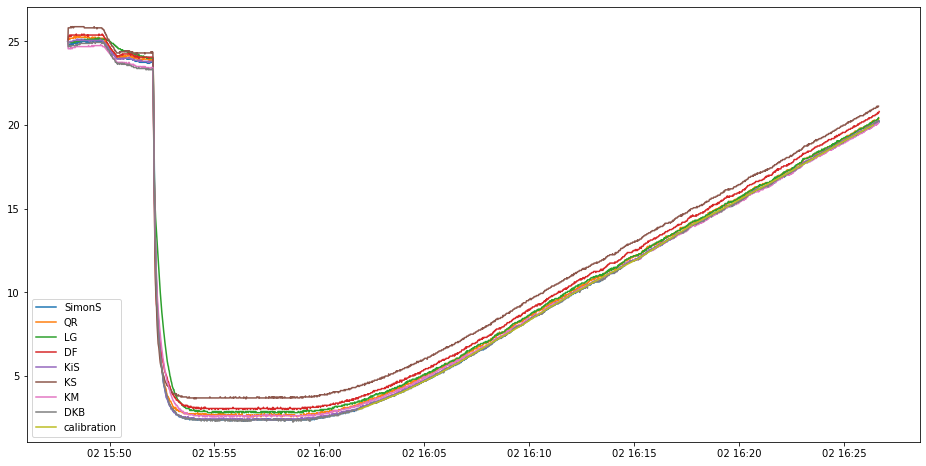

In [322]:
filenames = glob.glob("Tsensor_measurements/*.LOG")
print(filenames)

fig=plt.figure(figsize=(16,8))
path_storage = 'Tsensor_measurements/files_timeaxis/'
storage = ['SimonS.LOG', 'QR.LOG', 'LG.LOG', 'DF.LOG','KiS.LOG','KS.LOG','KM.LOG','DKB.LOG' ]

k=0
for filename in filenames:
    #load in all file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor["time"] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None)
    
    if (filename== filenames[2]) or (filename == filenames[6]):

        tsensor["time"] = tsensor["time"].copy()+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)

        for i in range(0,len(tsensor["time"].values)):
            tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
            
    #calculate offset to laboratoy measurement at shock time:
    print(filename.split("/")[-1].split("_")[-1].split(".")[0])
    offset = tsensor['time'].values[millis_start[k]]-start_shock
    print('shock time old:', tsensor['time'][millis_start[k]])
    print('offset: ', tsensor['time'][0] - offset)
    
    tsensor['time'] = tsensor['time']- offset
    
    #print the shock time:
    print('shock time: ', tsensor['time'][millis_start[k]])
        #tsensor["time"] = tsensor["time"]+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)
    print('start time: ', tsensor['time'][0])
    
    plt.plot(tsensor['time'], tsensor['temperature'], label=filename.split("/")[-1].split("_")[-1].split(".")[0])
    
    
    
    
    tsensor.to_csv(path_storage + storage[k], header=None, index=False)
    k+=1
    
plt.plot(calibration_2['time'], calibration_2['temperature'], label='calibration')
plt.legend()
plt.show()

In [323]:
calibration_2.dtypes

time           datetime64[ns]
millis                  int64
ID                     object
temperature           float64
dtype: object

<AxesSubplot:xlabel='time'>

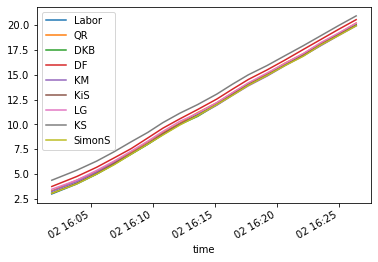

In [324]:
##load the files with the corrected time and create a dataframe with the same time axis

files = glob.glob(path_storage +"*")
variable = "temperature"
#print(files)

df1 = calibration_2.copy()
df_spot1 = df1[['time',variable]]
df_spot1 = df_spot1.rename(columns={variable: "Labor"})
df_spot1['time'] = pd.to_datetime(df1["time"], utc=True).dt.tz_localize(None)
df1 = df_spot1.copy()

for count, file in enumerate(files[:]):
    name = file.split("/")[-1].split("_")[-1].split(".")[0]
    #print(name)
    df2 = pd.read_csv(file, sep=',', comment='#',names=["time","millis","ID","temperature"])
    df2 = df2[["time",variable]]
    #print(df2.time.values[0])
    df2 = df2.rename(columns={variable: name})
    df2["time"] = pd.to_datetime(df2["time"], utc=True).dt.tz_localize(None)
    df_spot1 = pd.merge_ordered(df_spot1, df2)#, fill_method="ffill", left_by="group")
    
df_spot1["time"] = pd.to_datetime(df_spot1["time"], utc=True).dt.tz_localize(None)
df_spot1.set_index(['time'], inplace = True)

df_spot1 = df_spot1.interpolate(method = "time")
df_spot1 = df_spot1.reindex(df1.time)

sensor_list = df_spot1.columns.values.tolist()[:]

df_spot1.plot()

{'QR': array([ 0.00140693, -0.04060876,  0.44311093]), 'DKB': array([ 0.00119211, -0.02983068,  0.14389312]), 'DF': array([ 0.00171593, -0.04987637,  0.88662819]), 'KM': array([ 0.00219469, -0.06951533,  0.46263249]), 'KiS': array([ 0.00036888, -0.01093385,  0.09981709]), 'LG': array([ 0.00158846, -0.05031084,  0.58245583]), 'KS': array([ 1.47361701e-03, -6.23715667e-02,  1.58281494e+00]), 'SimonS': array([ 0.00075733, -0.02163417,  0.08605323])}


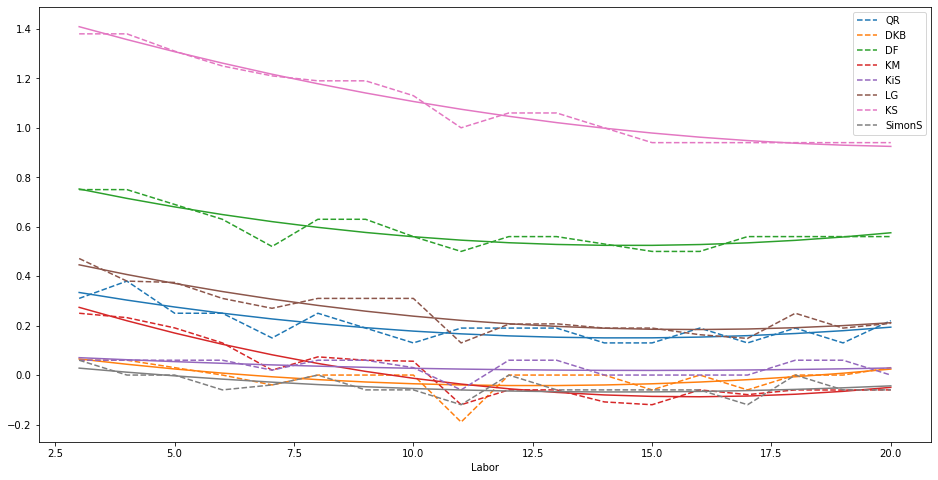

In [325]:
#%% find calibration

##fit gives constants a,b,c of the fit for y: y=a*x^2+ b*x +c
plt.figure(figsize = (16,8))
fit_y = np.zeros((len(sensor_list[1:]),len(df_spot1[sensor_list[0]])))
fit_parameter = {} 
for i, sensor in enumerate(sensor_list[1:]):
    ##fit values of labory with the difference between sensor and labatory, 2 is the order of polynom
    fit_parameter[sensor] = np.polyfit(df_spot1[sensor_list[0]].values, df_spot1[sensor].values-df_spot1[sensor_list[0]].values, 2)
    ##calculate the y-values of the fitted curve
    fit_y[i] = fit_parameter[sensor][2]+fit_parameter[sensor][1]*df_spot1[sensor_list[0]]+fit_parameter[sensor][0]*df_spot1[sensor_list[0]]**2
    
    #plot the fit 
    plt.plot(df_spot1[sensor_list[0]],fit_y[i])
    #plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor].values,label = sensor, alpha = 0.5,linestyle = "--")
    plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor].values-df_spot1[sensor_list[0]].values,label = sensor, alpha = 1,linestyle = "--",c=c[i])
#plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor_list[0]].values,label = sensor_list[0])   
plt.xlabel("Labor") 
plt.legend()

print(fit_parameter)

In [344]:
path_storage

'Tsensor_measurements/files_timeaxis/'

In [14]:
files_calib = glob.glob(path_storage+ '/*.LOG')
print(files_calib)

fig=plt.figure(figsize=(16,8))
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
              '#7f7f7f', '#bcbd22', '#17becf']
path_storage_calib = path_storage + '/calib/'
print(path_storage_calib)
storage = ['QR.LOG', 'DKB.LOG', 'DF.LOG', 'KM.LOG','KiS.LOG','LG.LOG','KS.LOG','SimonS.LOG' ]

k=0
for filename in files_calib:
    #load in all file by file
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    tsensor['time'] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None) 
    #print(name)
    #print('old start temp: ', tsensor['temperature'][:3])
    tsensor['temperature'] = tsensor['temperature'] - (fit_parameter[name][2]+tsensor['temperature']*
                                                       fit_parameter[name][1]+fit_parameter[name][0]*
                                                       test['temperature']**2)
    tsensor.to_csv(path_storage_calib + storage[k], header=None, index=False)
    
    plt.plot(tsensor['time'], tsensor['temperature'])
    k+=1

NameError: name 'path_storage' is not defined

In [369]:
DF = pd.read_csv(path_storage + '/DF.LOG', sep=',', comment='#',names=["time","millis","ID","temperature"])
DF['time'] = pd.to_datetime(DF["time"], utc=True).dt.tz_localize(None) 
KS = pd.read_csv(path_storage + '/KS.LOG', sep=',', comment='#',names=["time","millis","ID","temperature"])
KS['time'] = pd.to_datetime(KS["time"], utc=True).dt.tz_localize(None) 

In [370]:
DF['temperature'] = DF['temperature'] - (fit_parameter['DF'][2]+test['temperature']*fit_parameter['DF'][1]
                                             +fit_parameter['DF'][0]*test['temperature']**2)
KS['temperature'] = KS['temperature'] - (fit_parameter['KS'][2]+test['temperature']*fit_parameter['KS'][1]
                                             +fit_parameter['KS'][0]*test['temperature']**2)

(19418.66116898148, 19418.661712962963)

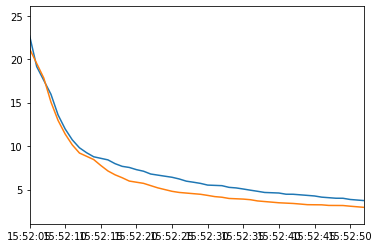

In [373]:
plt.plot(DF['time'], DF['temperature'])
plt.plot(KS['time'], KS['temperature'])
plt.xlim(KS['time'][210], KS['time'][250])

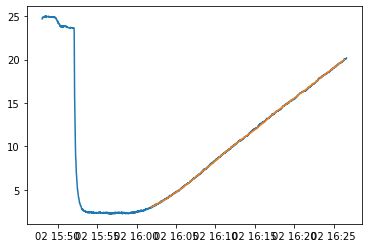

In [305]:
test['time'] = pd.to_datetime(test["time"], utc=True).dt.tz_localize(None) 
plt.plot(test['time'], test['temperature'])
plt.plot(calibration_2['time'], calibration_2['temperature'])

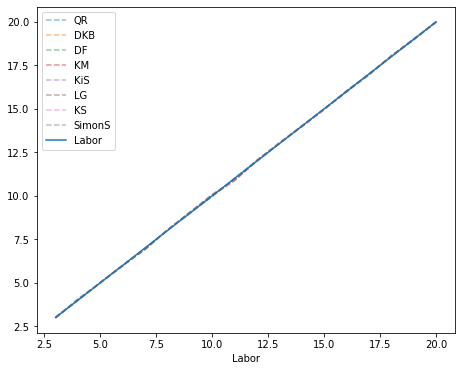

In [245]:
#%%
plt.figure(figsize = (7.5,6))
for i, sensor in enumerate(sensor_list[1:]):
    #plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor].values, alpha = 0.5,linestyle = ":",c=c[i])
    plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor].values-fit_y[i],label = sensor, alpha = 0.5,linestyle = "--",c=c[i])
plt.plot(df_spot1[sensor_list[0]].values,df_spot1[sensor_list[0]].values,label = sensor_list[0])   
plt.xlabel("Labor") 
plt.legend()

<AxesSubplot:xlabel='millis'>

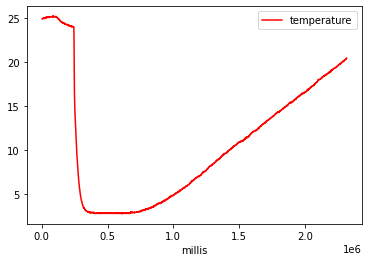

In [7]:
tsensor_lg.plot(x="millis", y="temperature", color='r')